# **Домашняя работа 3**

Будем практиковаться на [датасете](https://www.kaggle.com/c/avito-demand-prediction)

1.   Создать Dataset для загрузки данных (sklearn.datasets.fetch_california_housing)
2.   Обернуть его в Dataloader
3.   Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4.   Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25



С кагла дата сет не скачал так как не могу пройти вертификацию номера телефона

In [1]:
#Загрузка датасета
from sklearn.datasets import fetch_california_housing

In [3]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.7 MB/s eta 0:00:00


In [4]:
# Импорты библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from matplotlib import pyplot as plt

In [5]:
housing = fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False, as_frame=True)

In [6]:
df = housing['frame']
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [8]:
target = housing['target_names'][0]
target

'MedHouseVal'

In [9]:
features_list = housing['feature_names']
features_list

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [10]:
X = df[features_list]
y = df[target]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
print(f'Тренировочный набор: {X_train.shape}, {y_train.shape}')
print(f'Тестовый набор: {X_test.shape}, {y_test.shape}')

Тренировочный набор: (15480, 8), (15480,)
Тестовый набор: (5160, 8), (5160,)


In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train).float()
y_train = torch.FloatTensor(y_train.values).float()

X_test = torch.FloatTensor(X_test).float()
y_test = torch.FloatTensor(y_test.values).float()

## 1. **Dataset и Dataloader**

In [13]:
class MyOwnClass(torch.utils.data.Dataset):

    def __init__(self, X_data, y_data):
        self._X = X_data
        self._y = y_data

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        X = self._X[idx]
        y = self._y[idx]

        return X, y

In [14]:
train_dataset = MyOwnClass(X_train, y_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

In [15]:
train_dataset[0], train_dataset[0][0].shape, train_dataset[0][1].shape

((tensor([0.2081, 0.6863, 0.0243, 0.0226, 0.0379, 0.0011, 0.1775, 0.6096]),
  tensor(2.6800)),
 torch.Size([8]),
 torch.Size([]))

In [16]:
for idx, batch in enumerate(train_loader):
    print(idx, 'Tensor: ', batch[0], batch[0].shape)  # 128 батчей с 8 признаками
    print(idx, 'target: ', batch[1], batch[1].shape)  # 128 значений target
    break

0 Tensor:  tensor([[0.4479, 0.5098, 0.0428,  ..., 0.0015, 0.5792, 0.1853],
        [0.2194, 0.5490, 0.0254,  ..., 0.0028, 0.1690, 0.6345],
        [0.3400, 0.4510, 0.0358,  ..., 0.0017, 0.1807, 0.5279],
        ...,
        [0.2423, 0.2549, 0.0365,  ..., 0.0018, 0.8608, 0.2261],
        [0.4065, 0.0588, 0.0323,  ..., 0.0012, 0.5569, 0.2390],
        [0.2313, 0.3922, 0.0277,  ..., 0.0022, 0.1637, 0.6922]]) torch.Size([128, 8])
0 target:  tensor([4.2080, 1.3050, 2.7960, 2.1110, 1.3080, 1.4190, 1.5760, 1.1290, 5.0000,
        0.9910, 4.7840, 2.2460, 1.4580, 1.1120, 1.5350, 1.5690, 1.7940, 0.9000,
        2.0950, 1.8870, 1.6790, 1.6340, 1.2290, 2.8500, 3.6610, 1.7950, 1.3670,
        1.3910, 2.2500, 2.1250, 4.8690, 1.6310, 1.2930, 0.5650, 0.5760, 1.2980,
        5.0000, 1.9240, 2.2210, 0.8390, 0.8830, 0.8440, 1.0260, 2.2120, 2.8080,
        2.7610, 0.7390, 2.8750, 1.5310, 1.3810, 1.1170, 2.8810, 5.0000, 1.4460,
        0.8680, 3.7570, 5.0000, 2.3650, 3.2440, 0.6910, 2.3000, 1.3750, 2.6830,

In [17]:
test_dataset = MyOwnClass(X_test, y_test)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=8,
                                          shuffle=False,
                                          drop_last=True,
                                          num_workers=0)

## 2. Построение нейронной сети

In [18]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation

    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            return F.relu(x)
        raise RuntimeError

In [19]:
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 2*hidden_dim)
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(2*hidden_dim)
        self.fc2 = Perceptron(2*hidden_dim, hidden_dim)
        self.dp2 = nn.Dropout(0.2)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = Perceptron(hidden_dim, 1)

    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn3(x)
        x = self.fc3(x)
        return x

In [20]:
# Инициализация модели
net = FeedForward(8, 400)

# Компиляция модели
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [21]:
num_epochs = 15

In [22]:
train_r2 = torchmetrics.R2Score()
test_r2 = torchmetrics.R2Score()

In [25]:
net.train()
for epoch in range(num_epochs):
  running_loss, running_items = 0.0 , 0.0
  for i, data in enumerate(train_loader):
    inputs, target = data[0], data[1]

    optimizer.zero_grad()
    outputs = net(inputs)
    train_r2(outputs.squeeze(), target)
    loss = criterion(outputs.squeeze(), target)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_items += len(target)

    if i % 60 == 0:
      net.eval()

      print(f'Эпоха:[{epoch + 1}/{num_epochs}].' \
            f' Step:[{i + 1}/{len(train_loader)}].' \
            f' Loss:{running_loss / running_items:.3f},' \
            f' R2_train: {train_r2.compute().item():.3f}', end = ' ')
      running_loss, running_items = 0.0, 0.0
      train_r2.reset()

      for i, data in enumerate(test_loader):
        test_outputs = net(data[0])
        test_r2(test_outputs.squeeze(), data[1])

      print(f' R2_val: {test_r2.compute():.3f}')
      test_r2.reset()
      net.train()
print('Обучение завершено!')

Эпоха:[1/15]. Step:[1/120]. Loss:0.470, R2_train: 0.622  R2_val: 0.697
Эпоха:[1/15]. Step:[61/120]. Loss:0.393, R2_train: 0.707  R2_val: 0.738
Эпоха:[2/15]. Step:[1/120]. Loss:0.394, R2_train: 0.726  R2_val: 0.740
Эпоха:[2/15]. Step:[61/120]. Loss:0.354, R2_train: 0.734  R2_val: 0.733
Эпоха:[3/15]. Step:[1/120]. Loss:0.364, R2_train: 0.709  R2_val: 0.682
Эпоха:[3/15]. Step:[61/120]. Loss:0.373, R2_train: 0.725  R2_val: 0.718
Эпоха:[4/15]. Step:[1/120]. Loss:0.224, R2_train: 0.716  R2_val: 0.724
Эпоха:[4/15]. Step:[61/120]. Loss:0.369, R2_train: 0.724  R2_val: 0.713
Эпоха:[5/15]. Step:[1/120]. Loss:0.334, R2_train: 0.725  R2_val: 0.748
Эпоха:[5/15]. Step:[61/120]. Loss:0.345, R2_train: 0.734  R2_val: 0.759
Эпоха:[6/15]. Step:[1/120]. Loss:0.216, R2_train: 0.731  R2_val: 0.713
Эпоха:[6/15]. Step:[61/120]. Loss:0.353, R2_train: 0.738  R2_val: 0.726
Эпоха:[7/15]. Step:[1/120]. Loss:0.396, R2_train: 0.722  R2_val: 0.762
Эпоха:[7/15]. Step:[61/120]. Loss:0.367, R2_train: 0.720  R2_val: 0.767

## 3.Модели нейронноый сети с разными оптимизаторами

In [32]:
def train_eval_model(model, optimizer, num_epochs):

  train_r2 = torchmetrics.R2Score()
  test_r2 = torchmetrics.R2Score()

  r2_train_list = []
  r2_test_list = []

  for epoch in range(num_epochs):

    model.train()
    for i, data in enumerate(train_loader):
      inputs, target = data[0], data[1]
      optimizer.zero_grad()
      outputs = model(inputs)
      batch_r2 = train_r2(outputs.squeeze(), target)
      loss = criterion(outputs.squeeze(), target)
      loss.backward()
      optimizer.step()

    model.eval()
    for i, data in enumerate(test_loader):
      inputs, target = data[0], data[1]
      outputs = model(inputs)
      test_r2(outputs.squeeze(), target)

    total_train_r2 = train_r2.compute()
    total_test_r2 = test_r2.compute()

    r2_train_list.append(total_train_r2)
    r2_test_list.append(total_test_r2)
    print(f'Эпоха {epoch + 1},' \
          f' r2_train = {total_train_r2}', \
          f' r2_val = {total_test_r2}')
    train_r2.reset()
    test_r2.reset()

  return r2_train_list, r2_test_list

In [39]:
def visual_metrics(r2_train_list, r2_test_list, optim):
  x = np.arange(1, 11, 1)
  y = r2_train_list
  y2 = r2_test_list

  plt.plot(x, y, label= 'R2_train')
  plt.plot(x, y2, label= 'R2_test')

  plt.title(f'Нейроная сеть с оптимизатором {optim}')
  plt.ylabel('R2')
  plt.xlabel('Эпох')
  plt.legend()
  plt.show()

In [34]:
torch.manual_seed(10)

### SGD

In [35]:
model = FeedForward(8, 400)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.0)
r2_train_list_SGD, r2_test_list_SGD = train_eval_model(model, optimizer, 10)

Эпоха 1, r2_train = 0.017322838306427002  r2_val = 0.4502796530723572
Эпоха 2, r2_train = 0.3981422781944275  r2_val = 0.4996601343154907
Эпоха 3, r2_train = 0.48378825187683105  r2_val = 0.5801624655723572
Эпоха 4, r2_train = 0.5234606266021729  r2_val = 0.591178297996521
Эпоха 5, r2_train = 0.5569790005683899  r2_val = 0.5861023664474487
Эпоха 6, r2_train = 0.5796942710876465  r2_val = 0.5690022706985474
Эпоха 7, r2_train = 0.6183960437774658  r2_val = 0.6320518255233765
Эпоха 8, r2_train = 0.6470893621444702  r2_val = 0.6853398084640503
Эпоха 9, r2_train = 0.6541188359260559  r2_val = 0.6411216259002686
Эпоха 10, r2_train = 0.6763498783111572  r2_val = 0.672605037689209


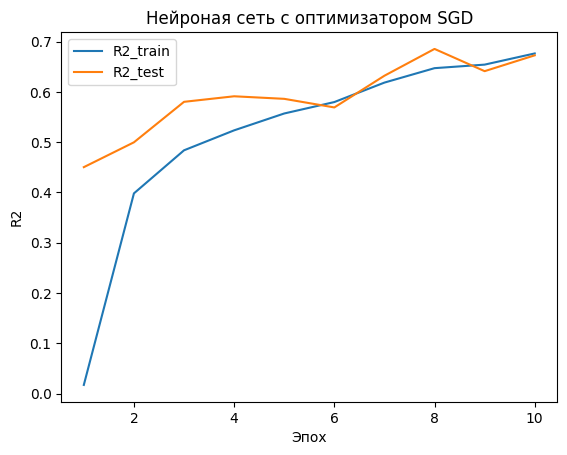

In [40]:
visual_metrics(r2_train_list_SGD, r2_test_list_SGD, 'SGD')

### Adam

In [43]:
model = FeedForward(8, 400)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
r2_train_list_Adam, r2_test_list_Adam = train_eval_model(model, optimizer, 10)

Эпоха 1, r2_train = -0.4434760808944702  r2_val = 0.17852842807769775
Эпоха 2, r2_train = 0.12239277362823486  r2_val = 0.3279106020927429
Эпоха 3, r2_train = 0.2556714415550232  r2_val = 0.37975889444351196
Эпоха 4, r2_train = 0.33634233474731445  r2_val = 0.4152764081954956
Эпоха 5, r2_train = 0.3933907747268677  r2_val = 0.48577868938446045
Эпоха 6, r2_train = 0.42388850450515747  r2_val = 0.5115045309066772
Эпоха 7, r2_train = 0.45691627264022827  r2_val = 0.5372011661529541
Эпоха 8, r2_train = 0.47324854135513306  r2_val = 0.5466822385787964
Эпоха 9, r2_train = 0.4880470037460327  r2_val = 0.5506002902984619
Эпоха 10, r2_train = 0.5088078379631042  r2_val = 0.5620620846748352


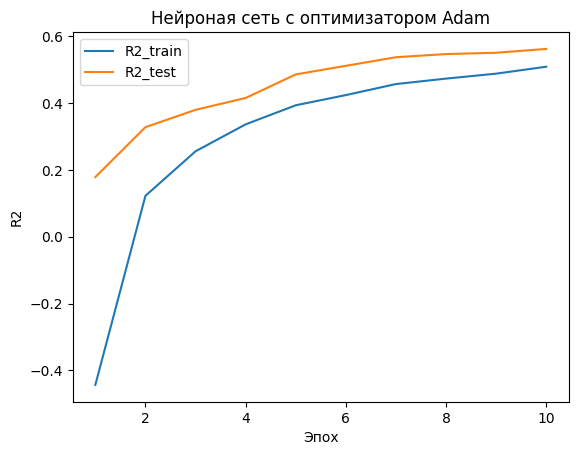

In [44]:
visual_metrics(r2_train_list_Adam, r2_test_list_Adam, 'Adam')

### RMSprop

In [45]:
model = FeedForward(8, 400)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
r2_train_list_RMSprop, r2_test_list_RMSprop = train_eval_model(model, optimizer, 10)

Эпоха 1, r2_train = 0.026604533195495605  r2_val = 0.3161078691482544
Эпоха 2, r2_train = 0.2977941036224365  r2_val = 0.43097007274627686
Эпоха 3, r2_train = 0.38113677501678467  r2_val = 0.46237921714782715
Эпоха 4, r2_train = 0.4135321378707886  r2_val = 0.4699978232383728
Эпоха 5, r2_train = 0.4470067620277405  r2_val = 0.5480819940567017
Эпоха 6, r2_train = 0.4729006886482239  r2_val = 0.5375664234161377
Эпоха 7, r2_train = 0.48995983600616455  r2_val = 0.5782178044319153
Эпоха 8, r2_train = 0.5070213079452515  r2_val = 0.5727702975273132
Эпоха 9, r2_train = 0.5197067856788635  r2_val = 0.5977083444595337
Эпоха 10, r2_train = 0.5333149433135986  r2_val = 0.5614514946937561


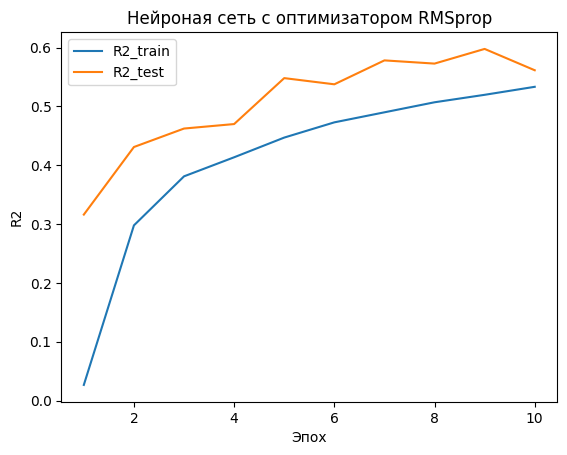

In [46]:
visual_metrics(r2_train_list_RMSprop, r2_test_list_RMSprop, 'RMSprop')

## Выводы

In [49]:
metrics_result = pd.DataFrame([{'r2_train': r2_train_list_SGD[-1].item(), 'r2_test': r2_test_list_SGD[-1].item()},
                               {'r2_train': r2_train_list_Adam[-1].item(), 'r2_test': r2_test_list_Adam[-1].item()},
                               {'r2_train': r2_train_list_RMSprop[-1].item(), 'r2_test': r2_test_list_RMSprop[-1].item()}],
                              index =['SGD', 'Adam', 'RMSprop'],
                              columns =['r2_train', 'r2_test'])

metrics_result.sort_values(by='r2_test', ascending=False)

,r2_train,r2_test
SGD,0.676350,0.672605
Adam,0.508808,0.562062
RMSprop,0.533315,0.561451


**Вывод:** лучшее результаты показала модель с приминением опртимизатора SGD